* ### Introduction
* ### Data Import
* ### Data Transformation and Exploration
    * Check Data
    * One in 10 Rule
    * Non-machine Learning Classifiers
    * Data Exploration
      * Generl Overview
      * Repayment Status (PAY_X)
      * Social Status Predictors (SEX, EDUCATION, MARRIAGE)
      * Age (AGE)
      * Amount of Bill Statement (BILL_AMTX)
      * Amount of Previous Payment (PAY_AMTX)
      * Limit of Balance (LIMIT_BAL)
    * Data Transformation
      * Social Status and Dummy Variables
      * Logging Monetary Features
    * Predictors' Correlation
    * Сorrelation between Preditors and Dependent Variable
    * Summary
    * Outliers 
       * Logged data
       * Isolation Forest
* ### Methodology Overview
     * Data Prepation
* ### Dimensionality Reduction
    * Principle Component Analysis(PCA)
    * Locally Linear Embedding (LLE)
* ### Predictive Models
    * Normal Logistic Regression 
    * Normal Logistic Regression with PCA
    * Normal Logistic Regression with LLE
    * Logistic Regression with Grid Search (Hyperparameter Tuning)
    * Naive Bayes
    * K-Neighbours
    * Random Forest
    * Random Forest with GINI criterion and boosted parameters
    * Gradient Tree Boosting
    * Kernel SVM
* ### Results
    * Logistic Regression with Grid Search (Hyperparameter Tuning)
    * Naive Bayes
    * K-Neighbours
    * Random Forest with GINI criterion and boosted parameters
    * Gradient Tree Boosting
    * Kernel SVM
* ### Final predictions on test set
* ### Reference


## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline 

from os import chdir
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

ModuleNotFoundError: No module named 'statsmodels'

## Introduction

Since this is quite a well-known dataset and problem, we first read through papers which aimed to explore the data set and create models which most accurately predicted credit card default. Having a look at [1] we see that they take an approach of using multiple different techniques including Logistic Regression, Naïve Bates and K-nearest neighbours, we took these approaches into consideration and applied these models along with many others to our transformed data. One thing which was not as well documented were approaches to pre-processing this data-set, we there set out to explore the data ourselves and had a look at how different features in the dataset influenced our target output and each other.  We found that some features played a bigger role than others in predicting credit card default. 

## Data Import

In [ ]:
# change the path to where you have downloaded the data set
path = os.getcwd()
chdir(path)
# set the path to our current working directory
data = pd.read_csv('CreditCard_train.csv', header =1)
isolation=data
outlierData=data
trainData = pd.read_csv('CreditCard_train.csv', header =1)
testData = pd.read_csv('CreditCard_test.csv', header =1)

## Data Transformation and Exploration

This section is split into two parts, where we first explore the data and then go onto manipulating the data according to the patters and inconsistencies we have noticed.

In [ ]:
# checking we have the correct data columns and glancing over the data
data.describe()

#### Generally looking at the dataset,from the 24000 sets of data:
* The mean of the the amount of given credit is around 165500, the standard deviation is extremly large this could possibly due to the max value being 1000000
* The average age is about 36. 
* The male-female ratio is about even (as the mean is 1.6)
* The majority of people graduate from either university or graduate school
* The mean of the "default payment next month" is 0.22, as 0 represents 'non-default' and 1 represents 'default' therefore possibly indicating most of the cases would not default next month


In [ ]:
# Create a list of the features and split them into categories so we can manipulate them
cols = [ f for f in data.columns if data.dtypes[ f ] != "object" and f!= 'ID']
del cols[-1:]
cols2 = cols
basicData = cols[1:11]
moneyData = [x for x in cols if x not in basicData]

We see that the values regarding amounts of money are heavily skewed to the left-hand side. We can try and eliminate this by transforming these features later. We will also have to keep this in mind when creating and evaluating our classifiers.

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize = (5,5))
plt.title('Default Credit Card Clients \n (Not Default = 0, Default = 1)')
ax = sns.countplot(x="default payment next month", data=data)

data['default payment next month'].astype(bool).sum(axis=0) 

total = float(len(data)) # one person per row 

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

### The one in ten rule

The one in ten rule is a rule of thumb for how many predictors can be derived from data when doing regression analysis without risk of overfitting. The rule states that one predictive variable can be studied for every ten events--minimum 10 events per varible. A "one in 20 rule" has been introduced, and sometimes considered better than "one in 10 rule" indicating more candidate events for each variable. In our case, firstly we need to get the output variable with the lower value: 5370
Then divide it by the number of variables: 5370/23=233. We definitely have enough number of candidates as the figure is more than 20. However, it might also indicates the high possibility for overfitting. We would do more exploration of th data to check that.

### Non-machine learning classifiers
There exist some very simple non-machine learning classifiers, for example:

* Random Guess Classifier : In our cases, randomly select 0 and 1 as the output

* Weighted Guess Classifier : randomly assign a % of the data to output 0 and the other 1-a% to 1

* Majority Class Classifier : assign all of the output to the majority  class in the data

These methods are so simple to implement and espically for the cases of logistis regression with only two output labels, the performance would be fairly well. Therefore a machine learning classifier should be smarter and gives better accuracy results than these algorithms.

It looks like that the majority class classifier would perform best on this set of data: 18630/24000=77.6%, so we should use a classifier giving higher accuracy than this

### Data Exploration
We plot each features distribution plot and look at how the distribution differs for defaulters and non-defaulters. We will also in this section look at different categories of features in more detail to closely examine their relations and determine if there are any inconsistencies with the data.

#### General overview

In [ ]:
#plotting the distribution plots
f = pd.melt(data, id_vars='default payment next month', value_vars= cols)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=5, sharex=False, sharey=False)
g = g.map( sns.distplot, "value", kde=True).add_legend()


From glancing at these plots, we can notice that the customers who default have a lower LIMIT_BAL than those who do not default, this makes sense if we think about the context. Other interesting things we notice is that those in lower levels of education tend to default more, however those who have a university level education tend to default the most out of other levels of education. IF we look at the plots for the payment status’, we see that those who do not default have a much higher proportion of zero or negative values for this feature.

In [ ]:
#we plot a correlation matrix for the features and target
corr = data.corr()
plt.subplots(figsize=(25,10))
from seaborn import heatmap
ax = heatmap(corr, annot=True)
plt.show()

From this we can see that our observation made from looking at the distribution plots were correct as we see how correlated the payment status's and education level are to the output. We are also able to see inner correlation between features and see that the repayment status over the 6 months are all highly correlated telling us that a customer is likely to remain consistent with the timeliness of their repayments

#### Repayment Status

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize = (20,15))
i = 0
for c in cols[5:11]:
    i= i+1
    plt.subplot(3,2,i)
    ax = sns.countplot(x=c, data=data, hue = "default payment next month")
    plt.tight_layout() 
    for p in ax.patches:
        if float(p.get_height()) > 0:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 2,
            '{:1.2f}'.format(p.get_height()/24000),
            ha="center")

In [ ]:
for c in cols[5:11]:
    hell = data[c].tolist()
    print('Number of 0s and -2s in '+ str(c)+':', hell.count(0)+hell.count(-2))
    print('Number of -2s:', hell.count(-2))

From the count plots, we observe that there are two unknown variables for repayment status: -2 and 0. Technically we should consider these variables as "NA" (Not Applicable) as they are undefined in the dataset and proceed to remove them or replace them with the median value. However, we can see that this would result in removing at least 17059 of our 24000 datapoint, not very ideal. Replacing them with the median would also not work as the median and the most prevalent value is 0. The distribution of these values do not seem random so they could potentially aid us in estimating the target output. We notice that the values of Payment status should range from [-1-9] excluding 0. We notice there are no recorded values for 9 for any of our 24,000 data points we therefore could shift the data and replace 0 with 1 , 2 with 3 and so forth till we replace 8 with 9 however this would lead us to also lose all values labelled as -2 which accumulates to around 15% of our data, we don’t think a shift in the data would benefit us more than holding onto this data so we decide to leave the data as it is.


#### Social Status (SEX, EDUCATION, MARRIAGE)

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize = (20,5))
i = 0
heights = []
for c in cols[1:4]:
    i= i+1
    plt.subplot(1,3,i)
    ax = sns.countplot(x=c, data=data, hue = "default payment next month")
    plt.tight_layout() 
    for p in ax.patches:
        if float(p.get_height()) > 0:
            height = p.get_height()
            heights.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 2,
            '{:1.2f}'.format(p.get_height()/24000),
            ha="center")
#Age
print('Proportion of Male defaulters:', '{:1.2f}'.format(heights[2]/heights[0]))
print('Proportion of Female defaulters:', '{:1.2f}'.format(heights[3]/heights[1]))

#Education
eduData = data['EDUCATION'].tolist()
print('Number of unexpected education data: ', eduData.count(5)+eduData.count(6)+eduData.count(0))

#Marriage Status
relData = data['MARRIAGE'].tolist()
print('Number of unexpected relationship data: ', relData.count(0)+relData.count(3))


From these count plots we can see that there a lot more females in our dataset then males. We can also see that men are more likely to default compared to women. Looking at the plot for the education we see that there are inconsistences since only the values 1,2,3 and 4 are defined. The values 0,5 and 6 could be due to errors, since there is a small amount of them we could get rid of these values by replacing the values with the value 4, thus categorising their education as others. We also realised that the ineffective way of representing the education, by assigning number values to different levels of education we are introducing a different level of meaning that is beyond education. For example, 3 is 3 times greater than 1, since 3 is representing grad school and 1 is representing high school does this translate to grad being worth 3 times more than high school? to remove this ambiguity we will introduce dummy variables later. For the Marriage we see that there are also some irregularities with the value 3 and that single customers have a smaller chance of defaulting.

In [ ]:
#check the inter-quartile range of the data 
print(data.AGE.quantile([0.25,0.5,0.75]))

One definition of outlier is any data point more than 1.5 inter-quartile range(IQR) below Q1 or above Q3. The IQR is 13, therefore outliers are points lying above 60.5 and below 8.5


In [ ]:
#Age 
plt.figure(figsize=(13,5))
col = data.columns[5]
sns.set(style="darkgrid")
ax=sns.countplot(x=str(col), data=data)
plt.axvline(x=39)
plt.show()

In [ ]:
#Age Scatter
fig, ax = plt.subplots()
data.plot.scatter(x='ID', y='AGE',c='AGE', cmap='viridis',ax=ax)
plt.show()

From the scatter plot, the strange thing is that with index more than 15000, the structure of the data seems like to have some kind of periodic patterns. To make sure that data with index more than 15000 is valid, we have drawed another histogram to analyse the strcture of the data.

In [ ]:
#figs, axs = plt.subplots(1, 2, figsize=(12, 3))
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
ax =sns.boxplot(x=data[col][:15000],color="#9b59b6").set_title("Before 15000 ")
plt.subplot(1,2,2)
ax = sns.boxplot(x=data[col][15000:]).set_title("After 15000 ")

plt.show()

 Both parts of the data hava the same structure and density, therefore the second part of the data is valid 

In [ ]:
#Amount of bill statement:
for c in range(1,7):
    string="BILL_AMT"+str(c)
    print(data[string].quantile([0.25,0.5,0.75]))

Again by making use of the definition of outlier:
 >Q3+1.5∗IQR or <Q1−1.5∗IQR


In the graphs belows, we add two imaginary lines indicting the lower bound and upeer bound for outliers

NameError: name 'data' is not defined

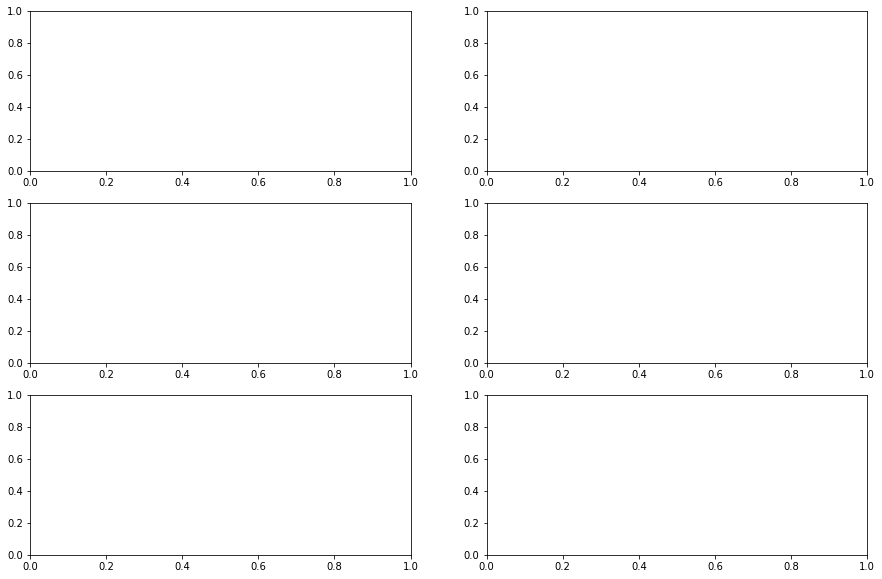

In [2]:
figs, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for counter in range(6):
    col = data.columns[12 + counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    distinct=len(data[col].unique())
    axs[counter].hist(data[col], bins=100,color='black',alpha=0.7,rwidth=1.5)
    axs[counter].axvline(x=low, color='r', linestyle='dashed', linewidth=2)
    axs[counter].axvline(x=high, color='r', linestyle='dashed', linewidth=2)
    axs[counter].grid(axis='y',alpha=0.75)
    axs[counter].set_title(" "+col)
plt.show()

In [ ]:
figs, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for counter in range(6):
    col = data.columns[12+counter]
    sns.boxplot(x=data[col],ax=axs[counter])
plt.show()


It looks like our current definition of outlier has a very limited range. The first solution is to give a higher bound for outliers, for example we could define Q3*1.5 IQR +300000 as the higher bound for outliers. Secondly we could also do some data tranformtion to this data. I would suggest try taking the log of the data because of negative values or set the upper bound to Q3*1.5 IQR +300000. 

In [3]:
#Amount of previous payment
for c in range(1,7):
    string="PAY_AMT"+str(c)
    print(data[string].quantile([0.25,0.5,0.75]))

NameError: name 'data' is not defined

For this sector, we do not have any more negative values now and use the same method as before

Obviously we could discard our lower bound for outliers as all the data is positive

NameError: name 'data' is not defined

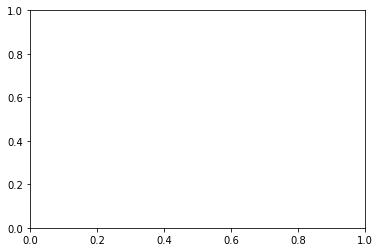

In [4]:
for counter in range(6):
    fig, ax = plt.subplots()
    col = data.columns[18+counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    data.plot.scatter(x='ID', y=col,c=col, cmap='viridis',ax=ax).set_title(" "+col)
    ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

plt.show()

Our current upper bound for outliers seems like it too low for this set of data

In [5]:
   print(data["LIMIT_BAL"].quantile([0,0.25,0.5,0.75,1]))

NameError: name 'data' is not defined

Remove the outliers and transfer the data back the original form

NameError: name 'data' is not defined

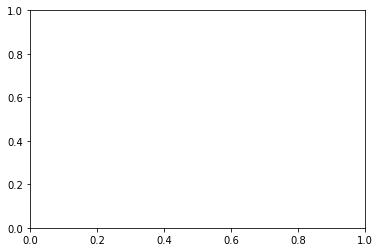

In [6]:
fig, ax = plt.subplots()
col = data.columns[1]
l,h=data[col].quantile([0.25,0.75])
rang=1.5*(h-l)
low=l-rang
high=h+rang
data.plot.scatter(x='ID', y=col,c=col, cmap='viridis',ax=ax).set_title(" "+col)
ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

### Data Transformations

#### Social status and Dummy variables

Initially, taking an overview of out data: 

Education is represented as numerical values which each represents a different level of education. We will replace this feature with some dummy categories as the the numbers 1, 2, 3 which represent Grad, Univeristy and High Shool education respecitvly will bring new meaning to these categories due to its mathemticla properties. We can eliminate this by replacing them with binary dummy variables. Using the same logic we also create binary dummy variables for Marriage and Sex.

In [7]:
#Education 
grad = (data['EDUCATION'] == 1).astype('int')
uni = (data['EDUCATION'] == 2).astype('int')
hs = (data['EDUCATION'] == 3).astype('int') 
others = (data['EDUCATION'] == 4).astype('int') ++ (data['EDUCATION'] == 6).astype('int') ++ (data['EDUCATION'] == 5).astype('int') ++ (data['EDUCATION'] == 0).astype('int')
data.insert(loc=3, column='GRAD_SCHOOL', value=grad)
data.insert(loc=3, column='UNIVERSITY', value=uni)
data.insert(loc=3, column='HIGH_SCHOOL', value=hs)
data.insert(loc=3, column='OTHERS' , value = others)
data = data.drop(columns = 'EDUCATION')

#Sex
male = (data['SEX'] == 1).astype('int')
data.insert(loc=3, column='MALE', value=male)
data = data.drop(columns = 'SEX')

#Marriage
marriage = (data['MARRIAGE'] == 1).astype('int')
data.insert(loc=8, column='MARRIED', value=marriage)
data = data.drop(columns = 'MARRIAGE')

NameError: name 'data' is not defined

From the initial visualisation we saw that the spread of the monetary features was very large, making it difficult to interpret its distribution. We transform these features by applying the log function. This will 'shrink' the value range while keeping the same logarithmic spread, allowing us to better visualise and apply functions to. We later show that impact of this transformation does not impact the number of outliers in our dataset, so the characteristics of the dataset remain similar.

#### Logging monetary features

In [8]:
logged = []

log_LB = data["LIMIT_BAL"].apply( lambda x: np.log1p(x) if x>0 else 0)
data.insert(loc=1, column='log_LIMIT_BAL', value=log_LB)
data = data.drop(columns = 'LIMIT_BAL')
logged.append("log_LIMIT_BAL")

for ii in range(1,7):
    iii  = data["BILL_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    data.insert(loc=16+ii, column="log_BILL_AMT" + str( ii ), value=iii)
    data = data.drop(columns = "BILL_AMT"  + str( ii ))
    logged.append("log_BILL_AMT" + str( ii ) )

for ii in range(1,7):
    iii  = data["PAY_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    data.insert(loc=21+ii, column="log_PAY_AMT" + str( ii ), value=iii)
    data = data.drop(columns = "PAY_AMT"  + str( ii ))
    logged.append("log_PAY_AMT" + str( ii ) )

NameError: name 'data' is not defined

We again plot the distribution of the monetary features with respect to the output, this time the data is logged allowing us to better interpret it.

In [9]:
f = pd.melt( data, id_vars='default payment next month', value_vars=logged)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=3, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

NameError: name 'data' is not defined

Looking at these plots we are able to see the relationship between these features and the outcome. We see that for lower values of log_LIMIT_BAL there are comaprativly more deafualtors compared to non-deafualtors. We also see that for  higher log_PAY_AMT the distributions of defaultors is quite low.

#### Isolation Forest: Removing Outliers

In [10]:
cols = list(data.columns)

rng = np.random.RandomState(24000)
clf = IsolationForest(max_samples='auto',
                      random_state=rng,)
cols = list(data.columns)
clf.fit(data[cols])
output_table = pd.DataFrame(clf.predict(data[cols]))
print('Outliers in normal data:')
print(output_table[0].value_counts())

clf.fit(data[logged])
output_table = pd.DataFrame(clf.predict(data[logged]))
print('Outliers in logged data:')
print(output_table[0].value_counts())

NameError: name 'data' is not defined

Using the traditional definition of the outliers is not a suitable choice for our set of data. As we have seen previously, using the formula: Q3+1.5∗IQR or <Q1−1.5∗IQR would delete large portion of data. Therefore, we used isolation forest which is an outlier detecting classifier to locate the outliers. 

Above figures shows that applying the isolation forest classifier on the original dataset and the logged dataset would give us the same number of outliers. Supproting that logging is a right transformtion of the data.

### Correlation with the 'default' variable

Here we have to transform some values of the data: set 1 to male and 2 = female, categorize the undocumented values of EDUCATION to others. Most importantly separating people into 4 age groups: younger than 25, 25-35 years old, 35-45 years old, 45 and plus. 

Below we would use -25 indicating ages that range from 0-25, -35 for range 25-35, -45 for range 36-45, 45 for 45 plus

In [11]:
# correlation between the social sectors
outlierData['SEX'] =outlierData['SEX'].map({1: 'male', 2: 'female'})
outlierData['MARRIAGE'] = outlierData['MARRIAGE'].map({1: 'married', 2: 'single',3:'others'})
outlierData['EDUCATION']=outlierData['EDUCATION'].map({ 0 :'others', 1 :'graduate school', 2 :'university', 3 :'high school', 4 :'others', 5 : 'others', 6 :'others'})
# a=pd.cut(outlierData['AGE'], [0, 25, 35, 45, 100])
# agegroup=outlierData['AGE'].groupby(a)
    
outlierData['AgeGroup'] = outlierData['AGE']
# At below, -25 indicating ages that range from 0-25
# -35 for range 25-35, -45 for range 36-45, 45 for 45 plus
for i, row in outlierData.iterrows():
    ifor_val=row['AgeGroup']
 
    if ifor_val<26:        
        outlierData.at[i,"AgeGroup"]='-25'
    elif ifor_val<36:
        outlierData.at[i,"AgeGroup"]='-35'
    elif ifor_val<46:
        outlierData.at[i,"AgeGroup"]='-45'
    else:
        outlierData.at[i,"AgeGroup"]='+45'

NameError: name 'outlierData' is not defined

In [12]:
# Age
mosaic(outlierData, ['AgeGroup','default payment next month'])
plt.xlabel("Age")
plt.ylabel("default payment")
plt.show()


NameError: name 'mosaic' is not defined

The biggest chances to default for age group under 25 and smallest for 25 - 34 age group.


NameError: name 'outlierData' is not defined

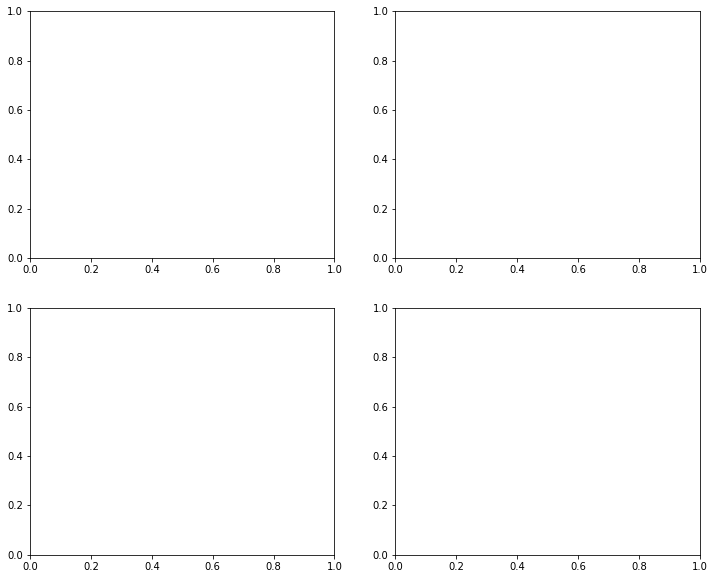

In [13]:
figs, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
distinct=outlierData['AgeGroup'].unique()
for counter in range(len(distinct)):
    mosaic(outlierData.loc[outlierData['AgeGroup']==distinct[counter]], ['SEX','default payment next month'],ax=axs[counter])
    axs[counter].set_title(" "+str(distinct[counter]))
plt.show()


Males are more likely to default than femals at all ages

NameError: name 'outlierData' is not defined

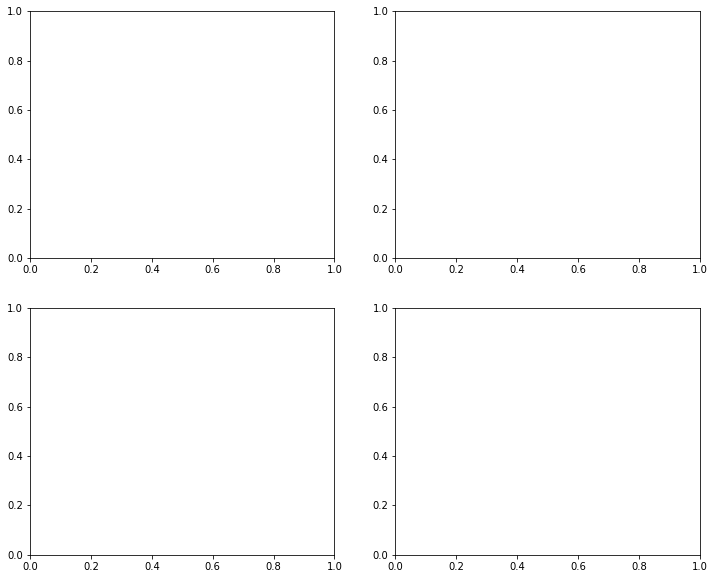

In [14]:
# Marriage and Age
figs, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
distinct=outlierData['AgeGroup'].unique()
for counter in range(len(distinct)):
    mosaic(outlierData.loc[outlierData['AgeGroup']==distinct[counter]], ['MARRIAGE','default payment next month'],ax=axs[counter])
    axs[counter].set_title("Age "+str(distinct[counter]))
plt.show()

Married people would increase the probability to default than singles

In [ ]:
# AGE, SEX and EDUCATION combination
figs, axs = plt.subplots(4, 2, figsize=(15, 10))
axs = axs.ravel()
distinct=outlierData['AgeGroup'].unique()
distinct1=outlierData['SEX'].unique()
c=0
for counter in range(len(distinct)):
    for counter1 in range(len(distinct1)):
        mosaic(outlierData[(outlierData['AgeGroup']==distinct[counter]) & (outlierData['SEX']==distinct1[counter1])], ['EDUCATION','default payment next month'],ax=axs[c])
        axs[c].set_title("AgeGroup "+str(distinct[counter])+" and Sex "+str(distinct1[counter1]))
        c+=1
plt.subplots_adjust( hspace = 0.5)
plt.show()

Generally we could obtain that higher education status would decrease the probability to default

In [ ]:
# Limit of Balance (LIMIT_BAL)
figs, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.ravel()
sns.boxplot(x=outlierData[outlierData['default payment next month']==0]['LIMIT_BAL'],color="#9b59b6",ax=axs[0]).set_title("default paymeny =0 ")
sns.boxplot(x=outlierData[outlierData['default payment next month']==1]['LIMIT_BAL'],ax=axs[1]).set_title("default paymeny =1 ")

plt.show()





In [ ]:
# Repayment Status (PAY_X)

figure=mosaic(outlierData, ['PAY_0','default payment next month'])
plt.show()


Although we have not included all the repayment status but it is obvious that the longer delay could lead to more chances to default

In [ ]:
# Age with Payment_0
figs, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
distinct=outlierData['AgeGroup'].unique()
for counter in range(len(distinct)):
    mosaic(outlierData.loc[outlierData['AgeGroup']==distinct[counter]], ['PAY_0','default payment next month'],ax=axs[counter])
    axs[counter].set_title("Age "+str(distinct[counter]))
plt.show()

In [ ]:
# Amount of bill statement:

figs, axs = plt.subplots(3, 2, figsize=(18, 10))
axs = axs.ravel()

sns.boxplot(x=outlierData[outlierData['default payment next month']==0]['BILL_AMT1'],color="#9b59b6",ax=axs[0]).set_title("default payment =0 ")
sns.boxplot(x=outlierData[outlierData['default payment next month']==1]['BILL_AMT1'],ax=axs[1]).set_title("default payment =1 ")
sns.boxplot(x=outlierData[outlierData['default payment next month']==0]['BILL_AMT2'],color="#8b59b6",ax=axs[2])
sns.boxplot(x=outlierData[outlierData['default payment next month']==1]['BILL_AMT2'],ax=axs[3])
sns.boxplot(x=outlierData[outlierData['default payment next month']==0]['BILL_AMT3'],color="#8b59b6",ax=axs[4])
sns.boxplot(x=outlierData[outlierData['default payment next month']==1]['BILL_AMT3'],ax=axs[5])
plt.subplots_adjust( hspace = 0.3)


figs, axs = plt.subplots(3, 2, figsize=(18, 10))
axs = axs.ravel()

sns.violinplot(x=outlierData[outlierData['default payment next month']==0]['BILL_AMT1'],color="#9b59b6",ax=axs[0]).set_title("default payment =0 ")
sns.violinplot(x=outlierData[outlierData['default payment next month']==1]['BILL_AMT1'],ax=axs[1]).set_title("default payment =1 ")
sns.violinplot(x=outlierData[outlierData['default payment next month']==0]['BILL_AMT2'],color="#8b59b6",ax=axs[2])
sns.violinplot(x=outlierData[outlierData['default payment next month']==1]['BILL_AMT2'],ax=axs[3])
sns.violinplot(x=outlierData[outlierData['default payment next month']==0]['BILL_AMT3'],color="#8b59b6",ax=axs[4])
sns.violinplot(x=outlierData[outlierData['default payment next month']==1]['BILL_AMT3'],ax=axs[5])
plt.subplots_adjust( hspace = 0.3)

plt.show()

Usuallt people with less amount of bill statement would be more likely to default

In [ ]:
# Amount of previous payment

figs, axs = plt.subplots(3, 2, figsize=(18, 10))
axs = axs.ravel()

sns.violinplot(x=outlierData[outlierData['default payment next month']==0]['PAY_AMT1'],color="#9b59b6",ax=axs[0]).set_title("default payment =0 ")
sns.violinplot(x=outlierData[outlierData['default payment next month']==1]['PAY_AMT1'],ax=axs[1]).set_title("default payment =1 ")
sns.violinplot(x=outlierData[outlierData['default payment next month']==0]['PAY_AMT2'],color="#8b59b6",ax=axs[2])
sns.violinplot(x=outlierData[outlierData['default payment next month']==1]['PAY_AMT2'],ax=axs[3])
sns.violinplot(x=outlierData[outlierData['default payment next month']==0]['PAY_AMT3'],color="#8b59b6",ax=axs[4])
sns.violinplot(x=outlierData[outlierData['default payment next month']==1]['PAY_AMT3'],ax=axs[5])
plt.subplots_adjust( hspace = 0.3)
plt.show()

Again, the smaller the payment amount, the bigger the chance of default.

## Summary about the predictors’  influences 
Generally talking about each of these variables:
* LIMIT_BAL Amount of the given credit:
    * the higher the amount of given credit, the less likely to default
* SEX, EDUCATION, MARRIAGE
    * Men are a bit more likely to default
    * Higher education usually leads to lower chances to default
    * Married persons have more chances to default.
* AGE
    * People from 25-35 are least likely to default
* PAY_ History of past payment
    * Delaying of the payment increases the likelihood to default
* BILL_AMT Amount of bill statement
    * Smaller amount of bill statement leads to higher chance to default
* PAY_AMT Amount of previous payment
    * The smaller amount of previous payment, the bigger chance to default

### Remove the outliers

In [ ]:
isolation=pd.read_csv('CreditCard_train.csv', header =1)
rng = np.random.RandomState(24000)
clf = IsolationForest(max_samples='auto',
                      random_state=rng,)
clf.fit(isolation)
output_table = pd.DataFrame(clf.predict(isolation))
print(output_table[0].value_counts())
# ax = sns.countplot(x=output_table[0],data=output_table)
# plt.show()

The outliers are marked by the -1 values, we can see that the isolation forest algorithm found 2400 of our data point to be outliers, we will therefore remove them from our dataset  

In [ ]:
# remove the outliers
result = pd.concat([isolation, output_table], axis=1, sort=False)
result=result.rename(columns={ result.columns[25]: 'output' })
result = result.drop(result[result.output == -1].index)
result=result.drop(columns = ['output'], axis = 1)


In [ ]:
# Visualisation of the new set of data without outliers
cols2 = [ f for f in result.columns if result.dtypes[ f ] != "object" and f!= 'ID']
del cols2[-1:]
#plotting the distribution plots
f = pd.melt(result, id_vars='default payment next month', value_vars= cols2)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=5, sharex=False, sharey=False)
g = g.map( sns.distplot, "value", kde=True).add_legend()

## Methodology Overview

### Data Preparation

In [ ]:
#Format headers for easier access and readability 
trainData.rename(columns={'default payment next month': 'default'}, inplace=True)
trainData.columns=trainData.columns.str.lower()

testData.rename(columns={'default payment next month': 'default'}, inplace=True)
testData.columns=testData.columns.str.lower()

X_train, y_train = trainData.drop(columns = [trainData.columns[0], 'default'], axis = 1), trainData.drop(trainData.columns[0:24], axis = 1)
X_test, y_test = testData.drop(columns = [testData.columns[0], 'default'], axis = 1), testData.drop(testData.columns[0:24], axis = 1)



#We now standardize the numerical featrues, 
#so that they have been rescaled to have a mean of zero and a standard deviation of one

numericalColoumns = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
              'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

X_train[numericalColoumns]=X_train[numericalColoumns].apply(lambda x: (x-np.mean(x))/np.std(x))
X_test[numericalColoumns]=X_test[numericalColoumns].apply(lambda x: (x-np.mean(x))/np.std(x))


#### Isolation Forest - Removing Outliers

In [ ]:
# recreating the Data without the outliers
result.rename(columns={'default payment next month': 'default'}, inplace=True)
result.columns=result.columns.str.lower()
iso_X_train, iso_y_train = result.drop(columns = [result.columns[0], 'default'], axis = 1), result.drop(result.columns[0:24], axis = 1)
numericalColoumns = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
              'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

iso_X_train[numericalColoumns]=iso_X_train[numericalColoumns].apply(lambda x: (x-np.mean(x))/np.std(x))



## Dimensionality Reduction

### Principle Component Analysis(PCA)

In [ ]:
# Conserve the variance to 95% 

from sklearn.decomposition import PCA
flat_list = [item for sublist in y_train.values for item in sublist]
pca = PCA(n_components=2)
projected = pca.fit_transform(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(projected)
print("Training data shape :", X_train.shape)
print("Projected data shape :", projected.shape)
print("Explained variance :", np.sum(pca.explained_variance_ratio_))
#plt.plot(cumsum)

sns.scatterplot(projected[:, 0], projected[:, 1], hue=flat_list)
#sns.scatterplot(projected)#, hue = y_train)
#d = np.argmax(cumsum >= 0.95) + 1
#print(d)
plt.show()

In [ ]:
# 95% of the variance is retained
pca = PCA(n_components=0.95)
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print (pca.explained_variance_)
print (pca.n_components_)
PCA_X_train=pca.fit_transform(X_train)

Here, by selecting the minimum number of principal components such that 95% of the variance is retained, we have 15 features left after dimentionality reduction and we would test the effect of this dataset later with our normal logistic regression

### Locally Linear Embedding (LLE)

Use LLE to find out the lowest optimal number of dimensions

In [ ]:
#Reducing number of features in x_train to 2
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X_train)

## Predictive Models

We start off with logistic regression as it a well-behaved classification algorithm. It is very useful when it can be trained with features that are roughly linear and the problem can belinearly separable. As seen in the visualisations above, certain features had strong linear correlations.

### Normal Logistic Regression 

In [ ]:
# Normal Logistic Regression classifer created
nlr_classifer=LogisticRegression()
nlr_classifer.fit(X_train,y_train.values.ravel())
#Prediction based on training data
Y_pred_logr=nlr_classifer.predict(X_train)
#Prediction based on testing data
Y_predict_logr=nlr_classifer.predict(X_test)
#Predict confidence scores for samples
prob_nlr = nlr_classifer.decision_function(X_test)

print("Score of Logistic Regression Model ","{0:.4f}".format(nlr_classifer.score(X_train,y_train)))


### Normal Logistic Regression without outliers

In [ ]:
# Normal Logistic Regression based on Isolation Forest Data

iso_nlr_classifer=LogisticRegression()
iso_nlr_classifer.fit(iso_X_train,iso_y_train.values.ravel())
Y_predict_iso_nlr=iso_nlr_classifer.predict(X_test)

#Confusion matrix created on test data
cm = confusion_matrix( y_test, Y_predict_iso_nlr )
ISO_NLRtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for NBClassifier = %.4f" % (ISO_NLRtestScore))


print("Score of Logistic Regression Model ","{0:.4f}".format(iso_nlr_classifer.score(iso_X_train,iso_y_train)))

### Normal Logistic Regression with PCA

In [ ]:
# Normal Logistic Regression with 2 features
nlr_pca_classifer=LogisticRegression()
nlr_pca_classifer.fit(PCA_X_train,y_train.values.ravel())


print("Score of Logistic Regression Model ","{0:.4f}".format(nlr_pca_classifer.score(PCA_X_train,y_train)))


### Normal Logistic Regression with LLE

In [ ]:
nlr_lle_classifer=LogisticRegression()
nlr_lle_classifer.fit(X_reduced,y_train.values.ravel())

print("Score of LLE Logistic Regression Model with LLE: ","{0:.4f}".format(nlr_lle_classifer.score(X_reduced,y_train)))

Using the training data produced from LLE and PCA, there is a 3% decrease in accuracy. Therefore, not that useful in training

### Logistic Regression with Grid Search (Hyperparameter Tuning)
Apply grid search to search for  best the hyper-parameter space for the optimal cross validation score

In [ ]:
log_reg_grid=[
    {'C':[0.001, 0.01, 0.1, 1, 1.01,1.1],
     'max_iter':[100,1000],'warm_start':['True','False']},
]
norm_log_reg=LogisticRegression()
#Grid Search optimization applied based on roc score
grid_search=GridSearchCV(norm_log_reg,log_reg_grid,cv=5,scoring='roc_auc')
grid_search.fit(X_train,y_train.values.ravel())

In [ ]:
print("Best Parameters:",grid_search.best_params_)

Store hyperparameters for tuning

In [ ]:
best_c_param=grid_search.best_params_.get('C')
best_max_iter_param=grid_search.best_params_.get('max_iter')
best_warm_start_param=grid_search.best_params_.get('warm_start')

In [ ]:
#New logistic regression classifier created based on tuned hyperparameters 
nlr_tuned_classifer=LogisticRegression(C=best_c_param,max_iter=best_max_iter_param,
                                  warm_start=best_warm_start_param)
nlr_tuned_classifer.fit(X_train,y_train.values.ravel())
Y_pred_nlr_tuned=nlr_tuned_classifer.predict(X_train)
Y_predict_nlr_tuned=nlr_tuned_classifer.predict(X_test)
prob_nlrTuned = nlr_tuned_classifer.decision_function(X_test)

print("Score of tuned Logistic Regression Model ","{0:.4f}".format(nlr_tuned_classifer.score(X_test,y_test)))

We obtain the best score of logistic regression after applying grid search optimization

### Naive Bayes

In [ ]:
nb_classifer = GaussianNB()
nb_classifer.fit( X_train, y_train.values.ravel() )
Y_predict_nb = nb_classifer.predict( X_test )
Y_probaNB = roc_auc_score(y_test, nb_classifer.predict_proba(X_test)[:,1])

print("Score of Naive Bayes Model ","{0:.4f}".format(nb_classifer.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_nb )
NBtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for NBClassifier = %.4f" % (NBtestScore))
rocScoresNB = cross_val_score( nb_classifer, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')


### K-Neighbours

In [ ]:
kn_classifer = KNeighborsClassifier(n_neighbors=10)
kn_classifer.fit( X_train, y_train.values.ravel() )
Y_predict_kn = kn_classifer.predict( X_test )
Y_probaKN = roc_auc_score(y_test, kn_classifer.predict_proba(X_test)[:,1])

print("Score of K-neightbours Model ","{0:.4f}".format(kn_classifer.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_kn )
KNtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for KNClassifier = %.4f" % (KNtestScore))
rocScoresKN = cross_val_score( kn_classifer, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')


The number of neightbors affects the accuracy on the test. When n = 5, we get an accuracy of 0.78, but when n = 10, we get 0.83. We tested this with much larger numbers, but the accuracy seems to converge to 0.83

### Random Forest

Tree Ensembles have huge advantages over LR. They do not expect linear features and handle categorical features very well. This is extremely useful in our case. Also,these algorithms perform very well in high dimensional spaces and large number of training examples.


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=10)
rf_classifier.fit( X_train, y_train.values.ravel() )
Y_predict_rf = rf_classifier.predict( X_test )

print("Score of Random Forest Model ","{0:.4f}".format(rf_classifier.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_rf )
print("Accuracy on Test Set for RandomForest = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
accScoresRF = cross_val_score( rf_classifier, X_train, y_train.values.ravel(), cv=10)
rocScoresRF = cross_val_score( rf_classifier, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')

# print("Mean RandomForest CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresRF.mean(), scoresRF.std() ))
# plot_confusion_matrix(Y_predict_rf)


### Random Forest with GINI criterion and boosted parameters

In [ ]:
RFC_METRIC = 'gini'  

rf_classifierGINI = RandomForestClassifier(n_jobs=4, 
                             random_state=2018,
                             criterion=RFC_METRIC,
                             n_estimators=100,
                             verbose=False)
rf_classifierGINI.fit( X_train, y_train.values.ravel() )
Y_predict_rfG = rf_classifierGINI.predict( X_test )
Y_probaRFG = roc_auc_score(y_test, rf_classifierGINI.predict_proba(X_test)[:,1])

print("Score of GINI Random Forest Model ","{0:.4f}".format(rf_classifierGINI.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_rfG )
RFGtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for RFGClassifier = %.4f" % (RFGtestScore))
rocScoresRFG = cross_val_score( rf_classifierGINI, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')

We used a validation criterion GINI. where GINI = 2 * (Receiver Operating Characteristic) - 1. This is more appropriate as data is unbalanced

### Gradient Tree Boosting

In [ ]:
gtb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gtb_classifier.fit(X_train, y_train.values.ravel())
Y_predict_gtb = gtb_classifier.predict( X_test )
Y_probaGTB = roc_auc_score(y_test, gtb_classifier.predict_proba(X_test)[:,1])

print("Score of GTB ","{0:.4f}".format(gtb_classifier.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_gtb )
GTBtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for GTB Classifier = %.4f" % (GTBtestScore))
rocScoresGTB = cross_val_score( gtb_classifier, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')



### Kernel SVM

In [ ]:
kSVM_classifier = SVC(kernel="rbf", probability=True)
kSVM_classifier.fit( X_train, y_train.values.ravel() )
Y_predict_kSVM = kSVM_classifier.predict( X_test )
Y_probakSVM = roc_auc_score(y_test, kSVM_classifier.predict_proba(X_test)[:,1])

print("Score of Kernel SVM ","{0:.4f}".format(kSVM_classifier.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_kSVM )
kSVMtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for k SVM Classifier = %.4f" % (kSVMtestScore))
rocScoreskSVM = cross_val_score( kSVM_classifier, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')

## Results

In [ ]:
# Function to generate confusion matrix
def plot_confusion_matrix(pred):
    conmat = np.array(confusion_matrix(y_test, pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['default', 'not default'], 
                             columns=['predicted default', 'predicted not default'])
    print(confusion)

In [ ]:
#Function to plot roc curve
def plot_roc(prob):
    y_score = prob
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y_test, y_score)
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure(figsize=[9,7])
    plt.plot(fpr[1], tpr[1], label='Roc curve (area=%0.2f)' %roc_auc[1], linewidth=4)
    plt.plot([1,0], [1,0], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('false positive rate', fontsize=18)
    plt.ylabel('true positive rate', fontsize=18)
    plt.title('ROC curve for credit default', fontsize=18)
    plt.legend(loc='lower right')
    plt.show()

### Logistic Regression with Grid Search (Hyperparameter Tuning)

In [ ]:
print(classification_report(y_test, Y_predict_nlr_tuned, target_names=['not default', 'default']))

In [ ]:
plot_confusion_matrix(Y_predict_nlr_tuned)

In [ ]:
plot_roc(prob_nlrTuned)

In [ ]:
print("Tuned Logistic Regression Model on test data: Accuracy - ","{0:.4f} Roc - 0.73".format(nlr_tuned_classifer.score(X_test,y_test)))

### Naive Bayes

In [ ]:
print(classification_report(y_test, Y_predict_nb, target_names=['not default', 'default']))

In [ ]:
plot_confusion_matrix(Y_predict_nb)

In [ ]:
print("Mean RocScore NaiveBayes CrossVal Accuracy %.4f, with std=%.4f" % (rocScoresNB.mean(), rocScoresNB.std() ))

In [ ]:
print("Accuracy on Test Set for NBClassifier = %.4f" % (NBtestScore))

In [ ]:
print("RocScore on Test Set for NBClassifier = %.4f" % (Y_probaNB))

### K-Neighbours

In [ ]:
print(classification_report(y_test, Y_predict_kn, target_names=['not default', 'default']))

In [ ]:
plot_confusion_matrix(Y_predict_kn)

In [ ]:
print("Mean RocScore K-Neighbours CrossVal Accuracy %.4f, with std=%.4f" % (rocScoresKN.mean(), rocScoresKN.std() ))

In [ ]:
print("Accuracy on Test Set for K-Neighbours = %.4f" % (KNtestScore))

In [ ]:
print("RocScore on Test Set for K-Neighbours = %.4f" % (Y_probaKN))

### Random Forest with GINI criterion and boosted parameters

In [ ]:
print(classification_report(y_test, Y_predict_rfG, target_names=['not default', 'default']))

In [ ]:
plot_confusion_matrix(Y_predict_rfG)

In [ ]:
print("Mean RocScore Random forest Gini CrossVal Accuracy %.4f, with std=%.4f" % (rocScoresRFG.mean(), rocScoresRFG.std() ))

In [ ]:
print("Accuracy on Test Set for Random forest Gini = %.4f" % (RFGtestScore))

In [ ]:
print("RocScore on Test Set for Random forest Gini = %.4f" % (Y_probaRFG))

### Gradient Tree Boosting

In [ ]:
print(classification_report(y_test, Y_predict_gtb, target_names=['not default', 'default']))

In [ ]:
plot_confusion_matrix(Y_predict_gtb)

In [ ]:
print("Mean RocScore GTB CrossVal Accuracy %.4f, with std=%.4f" % (rocScoresGTB.mean(), rocScoresGTB.std() ))

In [ ]:
print("Accuracy on Test Set for GTB = %.4f" % (GTBtestScore))

In [ ]:
print("RocScore on Test Set for GTB = %.4f" % (Y_probaGTB))

### Kernel SVM

In [ ]:
print(classification_report(y_test, Y_predict_kSVM, target_names=['not default', 'default']))

In [ ]:
plot_confusion_matrix(Y_predict_kSVM)

In [ ]:
print("Mean RocScore kernel SVM CrossVal Accuracy %.4f, with std=%.4f" % (rocScoreskSVM.mean(), rocScoreskSVM.std() ))

In [ ]:
print("Accuracy on Test Set for kernel SVM = %.4f" % (kSVMtestScore))

In [ ]:
print("RocScore on Test Set for kernel SVM = %.4f" % (Y_probakSVM))

## Conclusion

#### Receiver Operating Characteristic (ROC) score Rankings

1. Random Forest with Gini criterion (0.7773)
2. Gradient Tree Boosting (0.7703)
3. Naive Bayes (0.7555)
4. K-Neighbours (0.7403)
5. Logstic Regression (0.7300)
5. Kernel SVM (0.7216)
 
We decided to rank the predictive models in terms of ROC score, instead of accuracy, as it better represents the effectiveness of the algorithms. Since, the data is unbalanced (only 22% default), we care more about the accuracy in predicting true positives. Random Forest managed to predict to have the highest ratio of true positive to false negative. End-users such as banks would prefer this approach, as it accurately identifies people with defaults. However, approaches such as the Naive Bayes identified more defaults, but also made more mistakes. This is also useful; if the bank's objective was to identify as many customer's with defaults, regardless of mistakes. 

However, when looking at the approach with the most accuracy score, Kernel SVM took the lead with a score of 0.831. This is probably due to the fact that it trains well with complex and non-linear feature relations. However, it is very inefficient to train and consumes a lot of time. Logistic regression had one of the lowest scores due to it heavily depending on linear relations. We also coupled the algorithm with PCA and LLE, which actually made the score worse. Dimensionality reduction had no significant effect on the data, as the number of features is not too large. This showed the significance of several features and how they played a role in providing accurate predictions. Gridsearch was also used to optimize LR, however it had very little effect. On the other hand, when visualizing the data, we came across a large quantity of outliers. We attempted to remove these outliers through the process of Isolation Forest. This increased the accuracy score of the normal linear regression by 6%, indicating that LR is signficnatly affected by outliers. However, same tests conducted on other approaches such as Random Forest, did not yield in the same results.

We managed to dramatically increase and improve all metrics in each approach, by standardizing the data. Logistic regression accuracy scores rose by 5%. Naive Bayes improved from a test accuracy score of 30% to above 70%. We also managed to improve Random Forest scores, by proving more specific parameters such as the GINI criterion. This was more appropriate, as it validated the model with the ROC score. Cross-validation also played an important role in increasing the scores. 

We would like to build and train more complex models such as Neural networks in the future. We would want to see if they would perform better or worse than the current models. However, we learnt that ensemble methods such Random Forest perform well in datasets such as this, because they work well out of the box. They don't expect linear features, handle large dimension spaces and deal very well with categorical data.

## References

1. Principal Component Analysis, Wikipedia Page, https://en.wikipedia.org/wiki/Principal_component_analysis
2. RandomForrestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
3. ROC-AUC characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve
4. LogisticRegression, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
5. SVMs, https://scikit-learn.org/stable/modules/svm.html
6. Ensembles, https://scikit-learn.org/stable/modules/ensemble.html
7. Standarsize Data, https://stats.idre.ucla.edu/stata/faq/how-do-i-standardize-variables-in-stata/
8. Naive Bayes, https://scikit-learn.org/stable/modules/naive_bayes.html
9. Predicting with LR, https://medium.com/@guaisang/credit-default-prediction-with-logistic-regression-b5bd89f2799f
10. Isolation Forest https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e
11. Data Exploration https://rstudio-pubs-static.s3.amazonaws.com/281390_8a4ea1f1d23043479814ec4a38dbbfd9.html#limit-of-balance-limit_bal-1